In [62]:
!pip install pybaselines
from pybaselines import Baseline, utils
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, find_peaks_cwt


import numpy as np
from scipy.optimize import nnls
from numpy.linalg import norm

Current data is shaped: (1250, 100, 514)


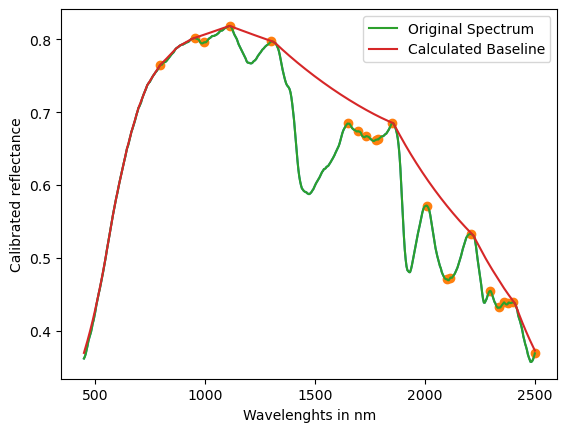

In [68]:
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')
# img = open_image('spectra/JA0464_18423_0001_20190207135542_00.procProf3d.hdr')
                 # image = 'spectra/JA0464_18423_0001_20190207135542_00.procProf3d.bin')
curr_data = envi.open('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr', image = 'spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.bin')

curr_data_array = curr_data.asarray()
print(f"Current data is shaped: {curr_data_array.shape}")

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)

# and the units
wav_unit = header['wavelength units']
n_bands = header['bands']

# Set the pixel we want for now

curr_x = 25
curr_y = 50

curr_pixel = curr_data_array[curr_x, curr_y, :]
plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelenghts in ' + wav_unit)
plt.ylabel('Calibrated reflectance')

# Get the peaks of the current spectrum
peaks = find_peaks(curr_pixel)[0]
# Append the end of the spectrum
peaks = np.append(peaks, curr_pixel.shape[0]-1)

plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')

# Invert the data 
pix_inverse = 1 / curr_pixel 

baseline_fitter = Baseline(wav_array,
                           check_finite=False)

# Calculate the baseline
baseline_inv = baseline_fitter.snip(pix_inverse,
                             max_half_window=40,
                             decreasing=True,
                             smooth_half_window=0)[0]

# Invert the result
curr_baseline = 1 / baseline_inv         

plt.plot(wav_array, curr_pixel, label='Original Spectrum')
plt.plot(wav_array, curr_baseline, label='Calculated Baseline')
plt.legend()



The input of the greedy-AGM procedure includes a mineral reflectance spectrum ρ(λ) and the associated noise covariance matrix Σ.

Given this, let's see if we can extract that covariance matrix which is an existing tool in pysptools

```
pysptools.material_count.HySime[source]
Hyperspectral signal subspace identification by minimum error.

count(M)
Hyperspectral signal subspace estimation.

Parameters:	M – numpy array Hyperspectral data set (each row is a pixel) with ((m*n) x p), where p is the number of bands and (m*n) the number of pixels.
Returns: tuple integer, numpy array
kf signal subspace dimension
Ek matrix which columns are the eigenvectors that span the signal subspace.
Reference:
Bioucas-Dias, Jose M., Nascimento, Jose M. P., ‘Hyperspectral Subspace Identification’, IEEE TRANSACTIONS ON GEOSCIENCE AND REMOTE SENSING, VOL. 46, NO. 8, AUGUST 2008.
```

In [42]:
# from pysptools.material_count import HySime
# from pysptools import material_count
# # test = HySime()
# # material_count.

# hs = HySime()
# test = material_count.vd
# test.hysime(curr_data_array)

import numpy as np

def estNoise(y,
             noise_type = 'poisson',
             verbose = 'off'):
    # if len(args) < 1 or len(args) > 3:
    #     raise ValueError("Invalid number of arguments")
    # if len(args) == 1:
    #     y, noise_type, verbose = args[0], 'additive', 'on'
    # elif len(args) == 2:
    #     y, noise_type, verbose = args[0], args[1], 'on'
    # else:
    #     y, noise_type, verbose = args[0], args[1], args[2]

    if not isinstance(y, np.ndarray):
        raise ValueError("The data set must an L x N matrix")

    L, N = y.shape
    if L < 2:
        raise ValueError("Too few bands to estimate the noise.")

    if verbose == 'on':
        print('Noise estimates:')

    if noise_type == 'poisson':
        sqy = np.sqrt(y * (y > 0))  # prevent negative values
        u, Ru = estAdditiveNoise(sqy, verbose)  # noise estimates
        x = (sqy - u) ** 2  # signal estimates
        w = np.sqrt(x) * u * 2
        Rw = np.dot(w, w.T) / N
    else:  # additive noise
        w, Rw = estAdditiveNoise(y, verbose)  # noise estimates

    if verbose == 'on':
        print('Noise correlation matrix:')
        print(Rw)

    return w, Rw


def estAdditiveNoise(r, verbose):
    small = 1e-6
    verbose = (verbose != 'off')
    L, N = r.shape
    w = np.zeros((L, N))

    if verbose:
        print('computing the sample correlation matrix and its inverse')

    RR = np.dot(r, r.T)  # equation (11)
    RRi = np.linalg.inv(RR + small * np.eye(L))  # equation (11)

    if verbose:
        print('computing band')

    for i in range(L):
        if verbose:
            print(f'\b\b\b{i+1}', end='')

        # equation (14)
        XX = RRi - np.outer(RRi[:, i], RRi[i, :]) / RRi[i, i]
        RRa = RR[:, i]
        RRa[i] = 0  # this remove the effects of XX[:, i]

        # equation (9)
        beta = np.dot(XX, RRa)
        beta[i] = 0  # this remove the effects of XX[i, :]

        # equation (10)
        w[i, :] = r[i, :] - np.dot(beta.T, r)  # note that beta[i] = 0 => beta[i] * r[i, :] = 0

    if verbose:
        print('\ncomputing noise correlation matrix')

    Rw = np.diag(np.diag(np.dot(w, w.T) / N))

    return w, Rw

s1,s2,s3 = curr_data_array.shape
reshaped_data = curr_data_array.reshape(s3, s1*s2)

# %    w is the noise estimates for every pixel (LxN)
# %    Rw is the noise correlation matrix estimates (LxL)

w, rw, = estNoise(reshaped_data, noise_type='poisson')


In [60]:
pixel_noise_ests = w.reshape(s1,s2,s3)
cov_matrix = rw

In [69]:
# Load in the data that's already had its hull removed
import pickle

# open a file, where you stored the pickled data
file = open('baseline_corrected_array.pickle', 'rb')

# dump information to that file
baseline_corrected_data = pickle.load(file)

# close the file
file.close()

In [106]:
def compute_EGO_Gaussian(params, lmbda):
    # EGO Gaussian function 
    si, mu_i, sigma_i, k_i = params
    return si * np.exp(-0.5 * ((lmbda - mu_i) ** 2 / (sigma_i - k_i * (lmbda - mu_i)) ** 2))

def create_dictionary(resolution, lmbda):
    # Define the range of each parameter
    mu_range = np.linspace(0, 1, resolution)
    sigma_range = np.linspace(0.1, 1, resolution)  # Assuming sigma cannot be 0
    k_range = np.linspace(0, 1, resolution)
    
    # Create a 3D grid for mu, sigma and k
    mu_grid, sigma_grid, k_grid = np.meshgrid(mu_range, sigma_range, k_range)
    
    # Flatten the grids to get a list of parameters for each Gaussian
    mu_list = mu_grid.flatten()
    sigma_list = sigma_grid.flatten()
    k_list = k_grid.flatten()
    
    # Initialize the dictionary
    size = resolution**3  # Total number of Gaussians
    dictionary = np.zeros((size, len(lmbda)))
    
    # Create a Gaussian for each point in the grid
    for i in range(size):
        params = [1, mu_list[i], sigma_list[i], k_list[i]]  # Magnitude s = 1
        dictionary[i, :] = compute_EGO_Gaussian(params, lmbda)
    
    return dictionary


def NNOMP(a, sigma, G, Nmax):
    r = np.dot(np.sqrt(np.linalg.inv(sigma)), a)
    s = np.zeros_like(a)
    S = set()

    for N in range(1, Nmax+1):
        l = np.argmax([np.dot(gi.T, np.dot(np.sqrt(np.linalg.inv(sigma)), r)) / norm(np.dot(np.sqrt(np.linalg.inv(sigma)), gi)) for gi in G if gi not in S])
        S.add(l)
        s[list(S)], _ = nnls(G[:, list(S)], a)
        r = np.dot(np.sqrt(np.linalg.inv(sigma)), (a - np.dot(G, s)))

    return s, r

# Usage

Nmax = 10  # Maximum number of iterations
# lmbda = np.linspace(1, 10, 100)  # lambda values for EGO Gaussian
G = create_dictionary(10, wav_array)  # Create dictionary
sigma = cov_matrix # Retrieve the noise matrix

a = baseline_corrected_data[25, 50, :]

# s, r = NNOMP(a,
#              sigma,
#              G,
#              Nmax)

# print(s)
# print(r)

G


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.18871977e-18, 2.19189288e-18, 2.19501463e-18, ...,
        2.50242987e-18, 2.50254731e-18, 2.50266439e-18],
       [3.92573806e-05, 3.92644690e-05, 3.92714340e-05, ...,
        3.99190186e-05, 3.99192526e-05, 3.99194859e-05],
       ...,
       [4.35480206e-01, 4.35498729e-01, 4.35516926e-01, ...,
        4.37191270e-01, 4.37191869e-01, 4.37192466e-01],
       [5.29400596e-01, 5.29415665e-01, 5.29430469e-01, ...,
        5.30792304e-01, 5.30792791e-01, 5.30793276e-01],
       [6.05170728e-01, 6.05182816e-01, 6.05194691e-01, ...,
        6.06287073e-01, 6.06287464e-01, 6.06287853e-01]])

```
r ← Σ−1/2a
s←0
S←∅
forN =1toNmax do
l ← arg maxi giT Σ−1/2r / ∥Σ−1/2gi∥, i ∈/ S
S ← S ∪ {l}
s(S) ← arg minz{∥Σ−1/2(a − GS z)∥2, z  0} sN ←s
rN ←Σ−1/2(a−GsN) end for
```

In [103]:
# def NNOMP(a, sigma, G, Nmax):
r = np.dot(np.sqrt(np.linalg.inv(sigma)), a)
s = np.zeros_like(a)
S = set()

# for N in range(1, Nmax+1):
#     l = np.argmax([np.dot(gi.T, np.dot(np.sqrt(np.linalg.inv(sigma)), r)) / norm(np.dot(np.sqrt(np.linalg.inv(sigma)), gi)) for gi in G if gi not in S])
#     S.add(l)
#     s[list(S)], _ = nnls(G[:, list(S)], a)
#     r = np.dot(np.sqrt(np.linalg.inv(sigma)), (a - np.dot(G, s)))

N = 0
gi = G[500,:]
gi.T

# l = np.argmax([np.dot(gi.T, np.dot(np.sqrt(np.linalg.inv(sigma)), r)) / norm(np.dot(np.sqrt(np.linalg.inv(sigma)), gi)) for gi in G if gi not in S])
# np.argmax([np.dot(gi.T, np.dot(np.sqrt(np.linalg.inv(sigma)), r)




# return s, r

/tmp/ipykernel_11157/847166052.py:2: RuntimeWarning: invalid value encountered in sqrt
  r = np.dot(np.sqrt(np.linalg.inv(sigma)), a)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.